In [11]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree
import random
import matplotlib.pyplot as plt
import time
import pickle



Считывание теоретических данных

In [12]:
df_th = pd.read_csv(r'c:\Users\trrak\OneDrive\Рабочий стол\platelets\project_FC\BD_platelets_regular.csv', sep=';')

columns_to_remove = [column for column in df_th.columns if re.search(r'\.', column)]
df_th = df_th.drop(columns_to_remove, axis=1)

columns_to_keep = ['r', 'eps', 'n', 'beta'] + [str(column) for column in range(10, 70)]
df_th = df_th[columns_to_keep]

df_th.head()

x_train = np.array(df_th)[:,4:]
y_train = np.array(df_th)[:,:4]

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.01, random_state=42, shuffle = True)

In [14]:
angles = np.array(df_th.columns[4:], dtype = 'int')

Считывание экспериментальных данных

In [15]:
df_ex = pd.read_csv(r'c:\Users\trrak\OneDrive\Рабочий стол\platelets\project_FC\experimental_1_degree.csv', sep=';')
df_ex = df_ex.drop('70', axis=1)

df_ex.head()

x_ex = np.array(df_ex)[:]

Основной код

In [40]:
class BD_search(object):

    def __init__(self):
        self.weight = None
        self.angles = None 
        self.x_train = None
        self.y_train = None
        self.kd_model = None
        self.ball_model = None
        self.is_weight = None
        
        
    def init_angles(self, _angles):
        self.angles = _angles
        self.weight_formula(self.angles)
        
    def weight_formula(self,_θ):
        self.weight = (1 / _θ) * np.exp(-2 * (np.log(_θ / 54)) ** 2)
    
    
    def brut_force_method(self, _x):
        __x = _x    
        # if len(_x.shape) == 1:
            # __x = np.reshape(_x, (1,-1))
        
        n = len(__x)
        m = len(self.y_train[0])
        k = len(self.x_train[0])
        
        _y = np.zeros((n, m))
        _x = np.zeros((n, k))
        for i in tqdm(range(n)):
            mse = np.mean((self.x_train - __x[i]) ** 2 , axis = 1)
            _y[i] = self.y_train[np.argmin(mse),:]
            _x[i] = self.x_train[np.argmin(mse),:]
            
        return _x, _y    
            
    
    def fit(self, _x, _y, weight = True):
        self.is_weight = weight
        
        __x, __y = np.array(_x), np.array(_y)
        
        if self.is_weight == True:
            self.x_train = __x * self.weight
        else:
            self.x_train = __x
            
        self.y_train = __y
        self.kd_model = KDTree(self.x_train, 10)
        self.ball_model = BallTree(self.x_train, leaf_size=10)
    
    def predict(self, _x, method='kd_tree'):
        _y = []
        __x = []
        
        
        if self.is_weight == True:
            _x = _x * self.weight
        else:
            _x = _x
            
        if method == 'kd_tree':
            time_one = time.time()
            dist, ind = self.kd_model.query(_x, k=1)
            time_two = time.time()
            time_all = (time_two - time_one) / len(_x)
            print(time_all)
            ind = np.reshape(ind , -1)
            _y = self.y_train[ind]
            __x = self.x_train[ind]
        
        if method == 'ball_tree':
            time_one = time.time()  
            dist, ind = self.ball_model.query(_x, k=1)
            time_two = time.time()
            time_all = (time_two - time_one) / len(_x)
            print(time_all)
            ind = np.reshape(ind , -1)
            _y = self.y_train[ind]
            __x = self.x_train[ind]
            
        if method == 'bd_search':
            __x, _y = self.brut_force_method(_x)

        return __x, _y

In [41]:
serc = BD_search()
serc.init_angles(angles)

In [42]:
serc.fit(x_train, y_train, weight=True)
# x_pred, y_pred = serc.predict(x_test, method='kd_tree')
# x_pred_simp, y_pred_simp = serc.predict(x_test, method='ball_tree')
x_pred_bd, y_pred_bd = serc.predict(x_test, method='bd_search')

100%|██████████| 1962/1962 [01:48<00:00, 18.03it/s]


In [47]:
def regr_model_resume(_y_test, _y_pred, params = ['r','eps', 'n', 'beta'], _title = '___________', method='kd_tree и ball_tree'):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    
    mse = mean_squared_error(_y_pred, _y_test, multioutput='raw_values',squared=False)
    mae = mean_absolute_error(_y_pred, _y_test, multioutput='raw_values')
    r2 = r2_score(_y_pred, _y_test, multioutput='raw_values')
    
    metrics= np.array([mae, mse, r2]).T
    metrics = np.around(metrics, 4)
    
    plt.figure(figsize=(20, 10))
    plt.suptitle(f'Метод: {method}', fontsize='40')
    N = len(params)
    M = 2
    for i in range(N):

        plt.subplot(M, N, i + 1)
        plt.title("Корреляционный график")
        plt.xlabel(params[i] + ' Тестовые')
        plt.ylabel(params[i] + ' Предсказанные')
        plt.plot(_y_test[:, i], _y_pred[:, i], '.', alpha = 0.3)
    
    plt.subplot(2, 1, 2)
    ax = plt.gca() 
    fig = plt.gcf()
    
    ax.axis('off')
    table = plt.table(cellText=metrics, colLabels = ['mae', 'mse', 'r2'], rowLabels = params, loc='center', colWidths=[0.1]*3)
    table.set_fontsize(17)
    table.scale(1,2)
    plt.subplots_adjust(hspace=1.0, wspace=0.5)
    
    plt.show()
    

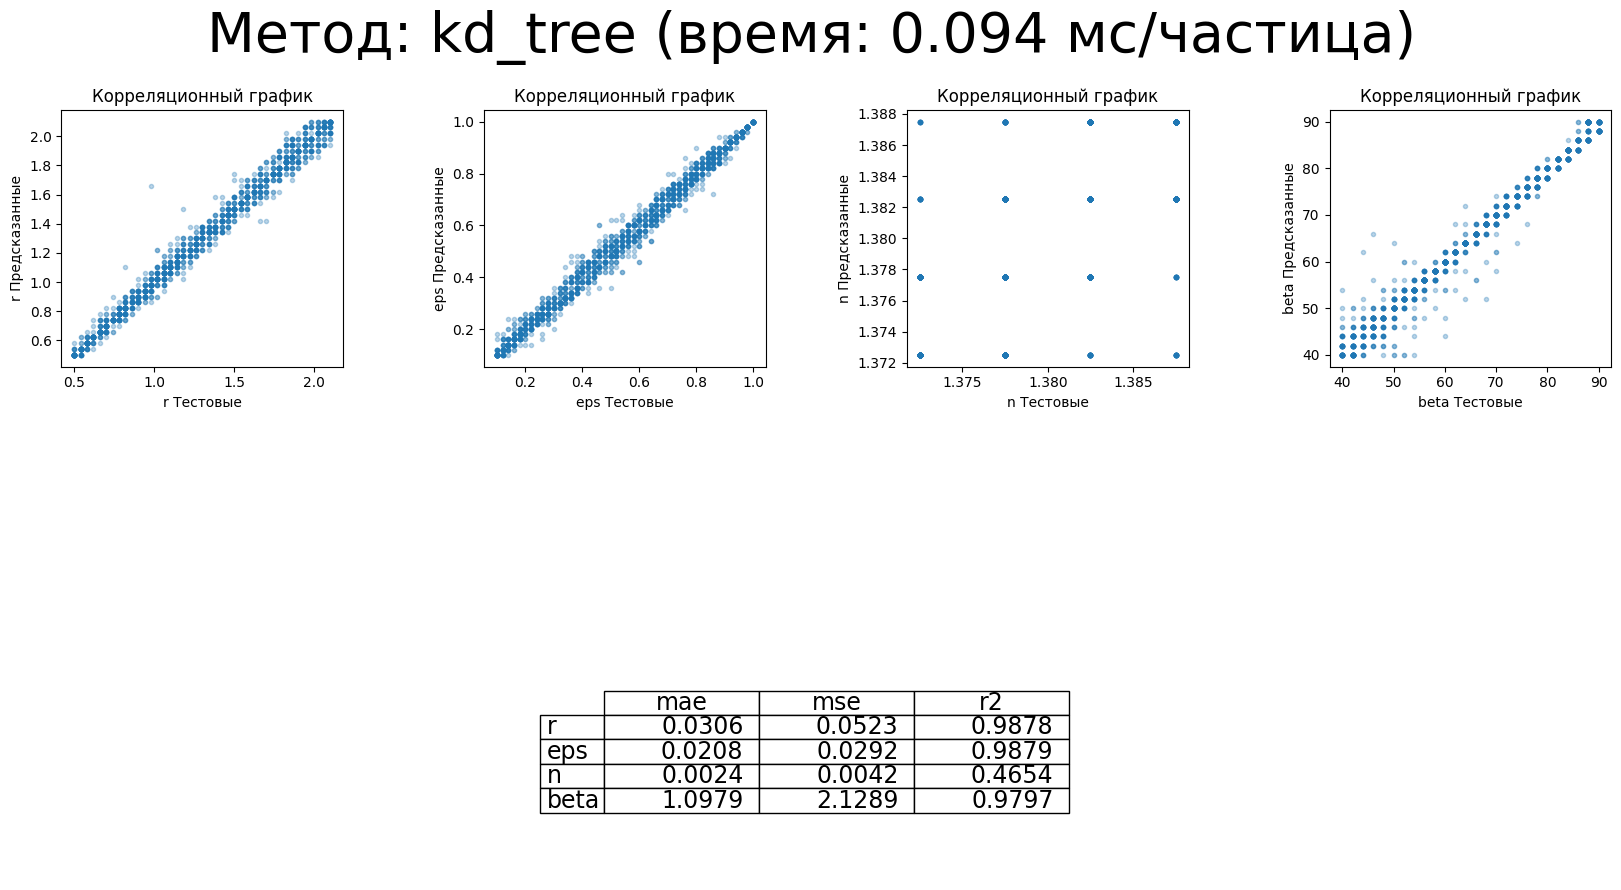

In [ ]:
regr_model_resume(y_pred, y_test)

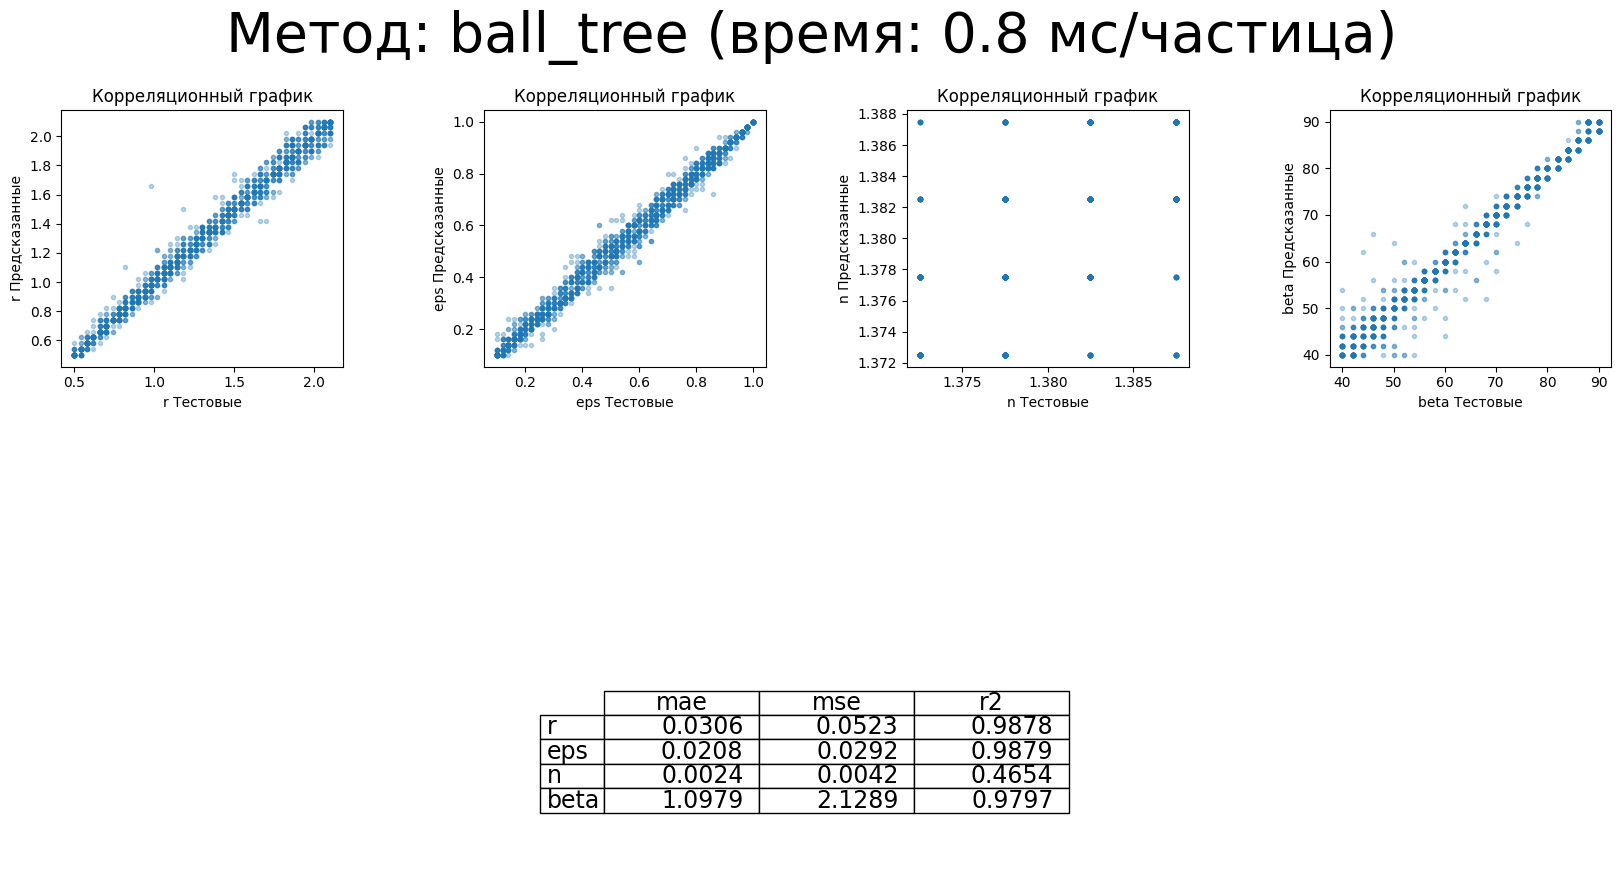

In [ ]:
regr_model_resume(y_pred_simp, y_test)

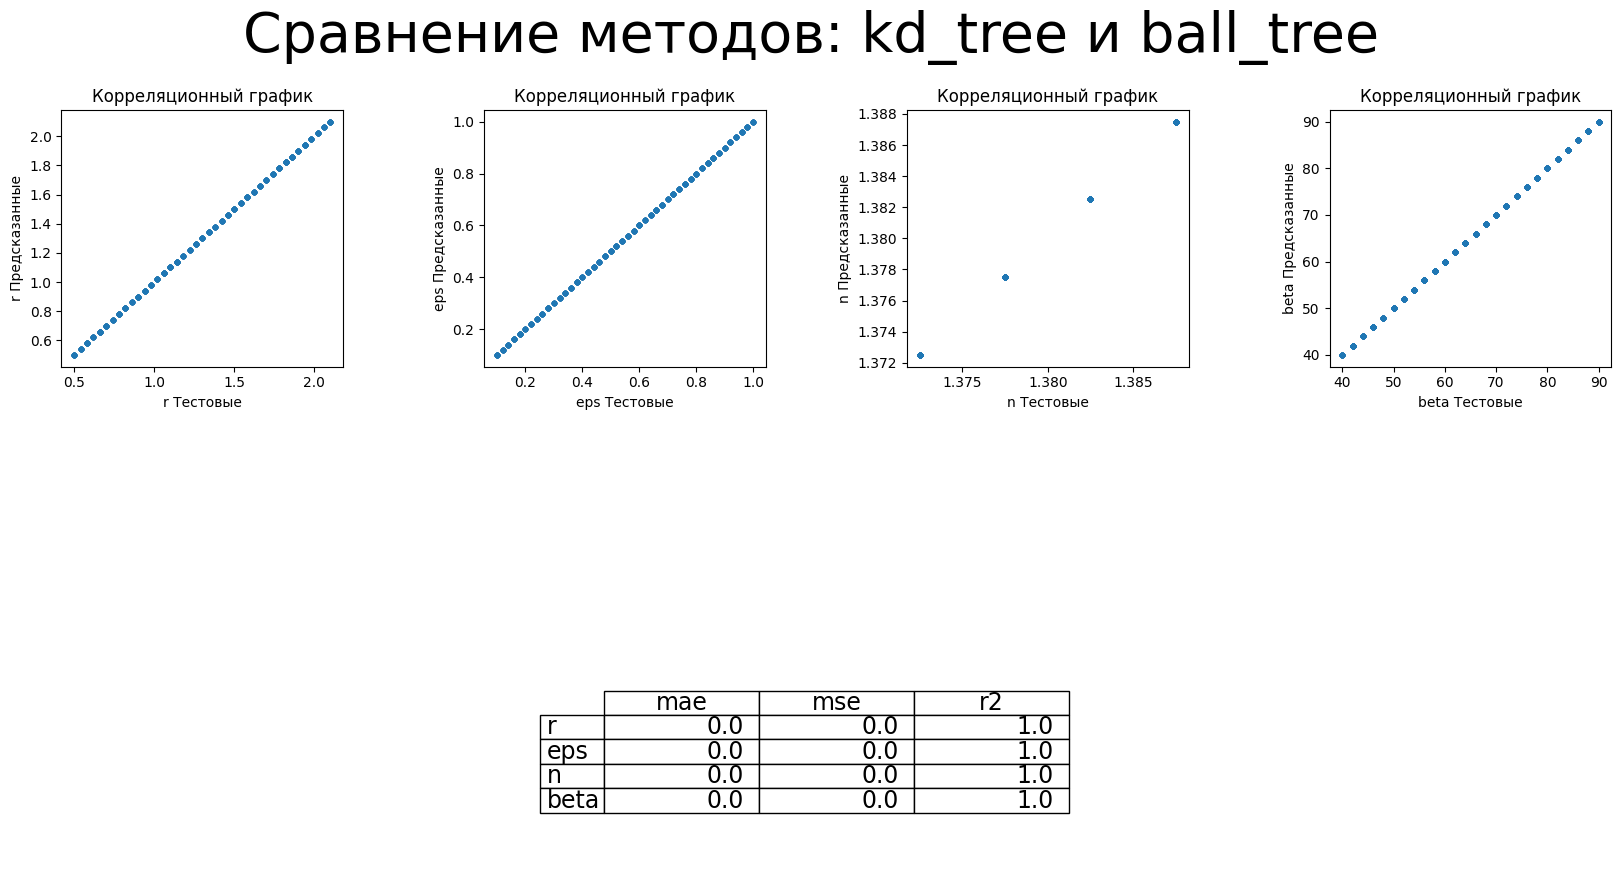

In [ ]:
regr_model_resume(y_pred_simp, y_pred)

In [28]:
def bd_model_resume(_x_test, _x_pred, params = ['r','eps', 'n', 'beta'], _title = '___________', method=''):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    
    rel_mse = mean_squared_error(_x_pred.T, _x_test.T, multioutput='raw_values', squared=False) / mean_squared_error(_x_pred.T* 0, _x_test.T , multioutput='raw_values', squared=False)
    rel_mse = rel_mse.T
    
    plt.figure(figsize=(20, 20))
    plt.suptitle(f'Метод: {method}', fontsize='50')
    N = 9
    
    for i in range(N):
        plt.subplot(3, 3, i + 1)
        plt.title(f"Сравнительный анализ графиков №{i+1} (MSE: {rel_mse[i]:.2e})")
        plt.plot(_x_test[i], '*', label = 'Тестовый')
        plt.plot(_x_pred[i], '-', label = 'Ближайший')
        plt.legend()

    
    plt.show()

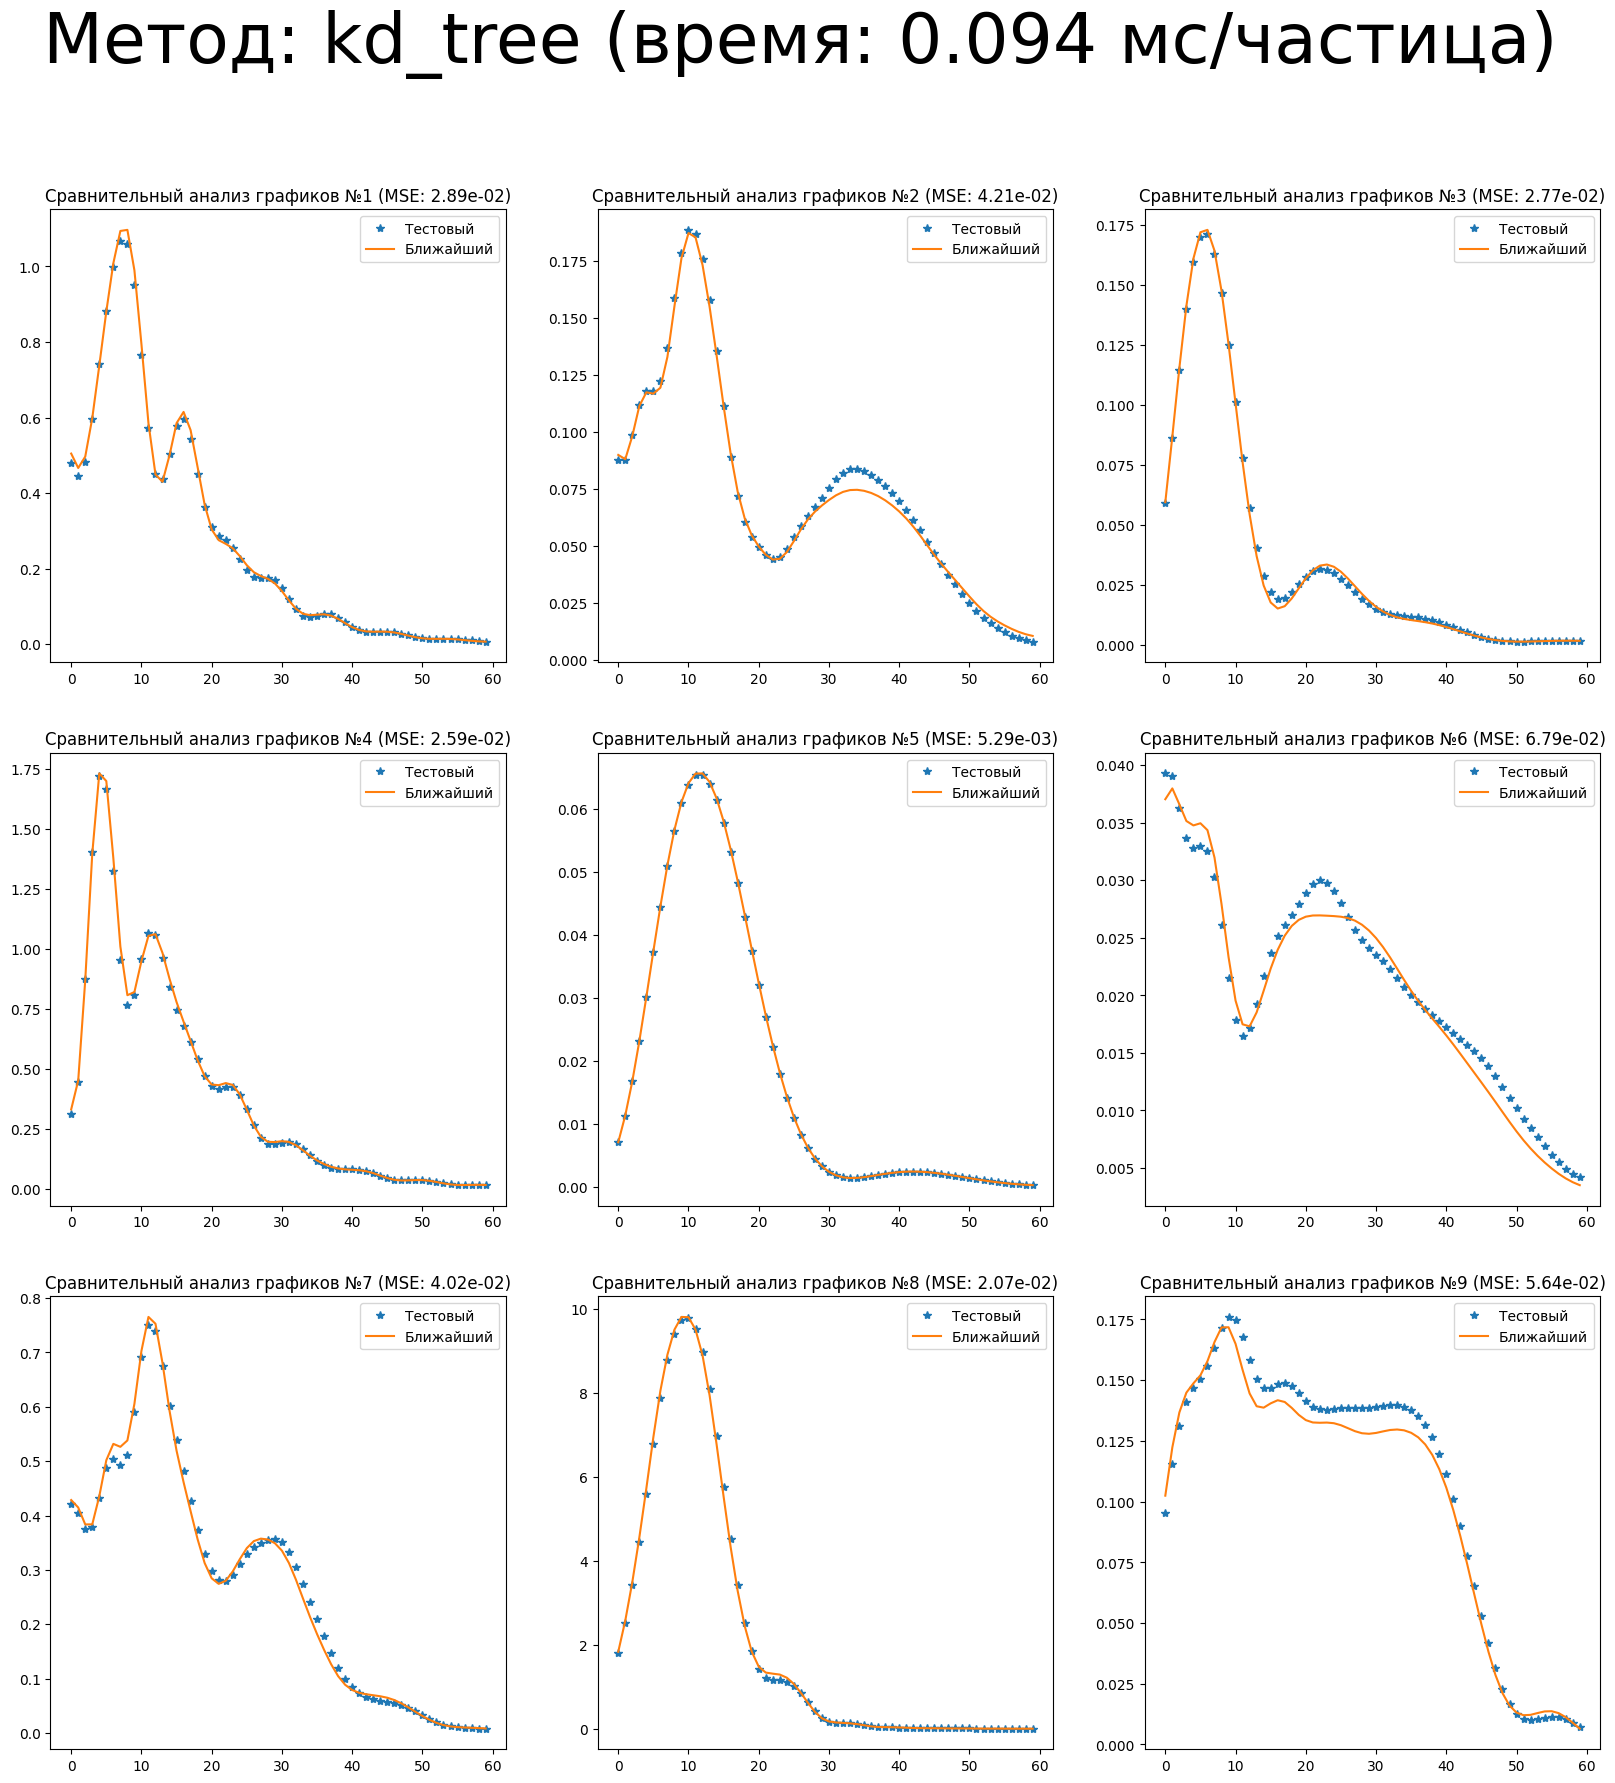

In [ ]:
bd_model_resume(x_test * serc.weight, x_pred, method='kd_tree (время: 0.094 мс/частица)')

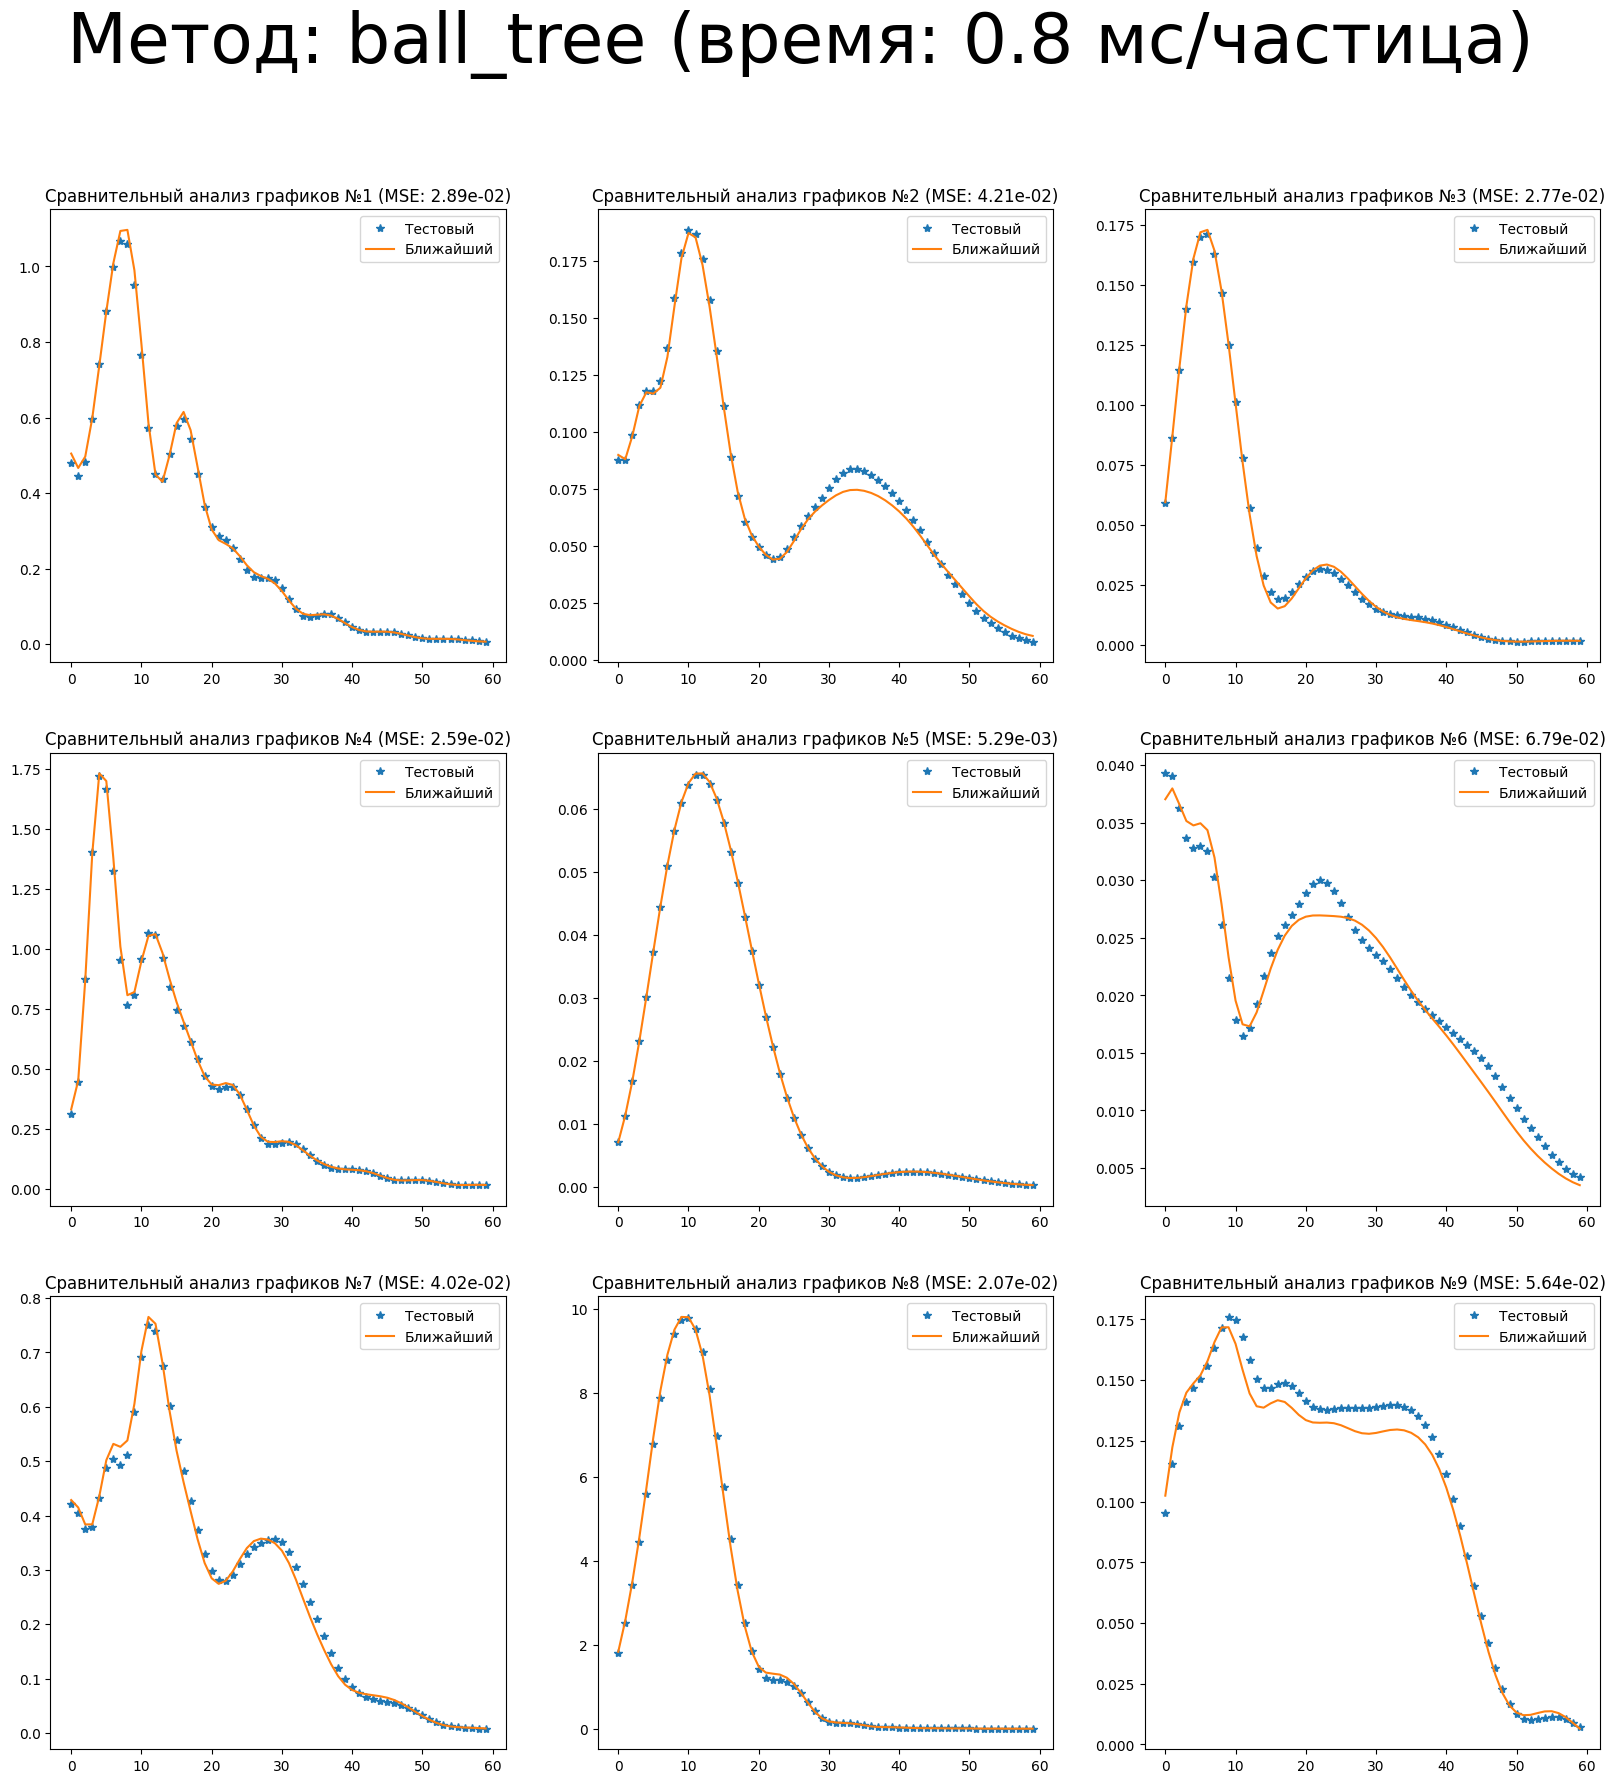

In [ ]:
bd_model_resume(x_test * serc.weight, x_pred_simp, method='ball_tree (время: 0.8 мс/частица)')

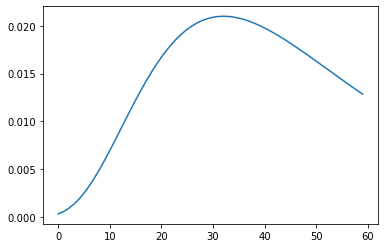

In [ ]:
plt.plot(serc.weight)

In [30]:
y_pred_bd

array([[ 0.5       ,  0.1       ,  1.37249994, 40.        ],
       [ 0.5       ,  0.1       ,  1.37249994, 40.        ],
       [ 0.5       ,  0.1       ,  1.37249994, 40.        ],
       ...,
       [ 0.5       ,  0.1       ,  1.37249994, 40.        ],
       [ 0.5       ,  0.1       ,  1.37249994, 40.        ],
       [ 0.5       ,  0.1       ,  1.37249994, 40.        ]])

In [31]:
y_pred

array([[ 1.89999998,  0.89999998,  1.37249994, 80.        ],
       [ 1.38      ,  0.40000001,  1.38250005, 50.        ],
       [ 0.74000001,  0.89999998,  1.37750006, 44.        ],
       ...,
       [ 1.98000002,  0.92000002,  1.38750005, 66.        ],
       [ 0.86000001,  0.12      ,  1.37750006, 64.        ],
       [ 0.86000001,  0.83999997,  1.38250005, 78.        ]])

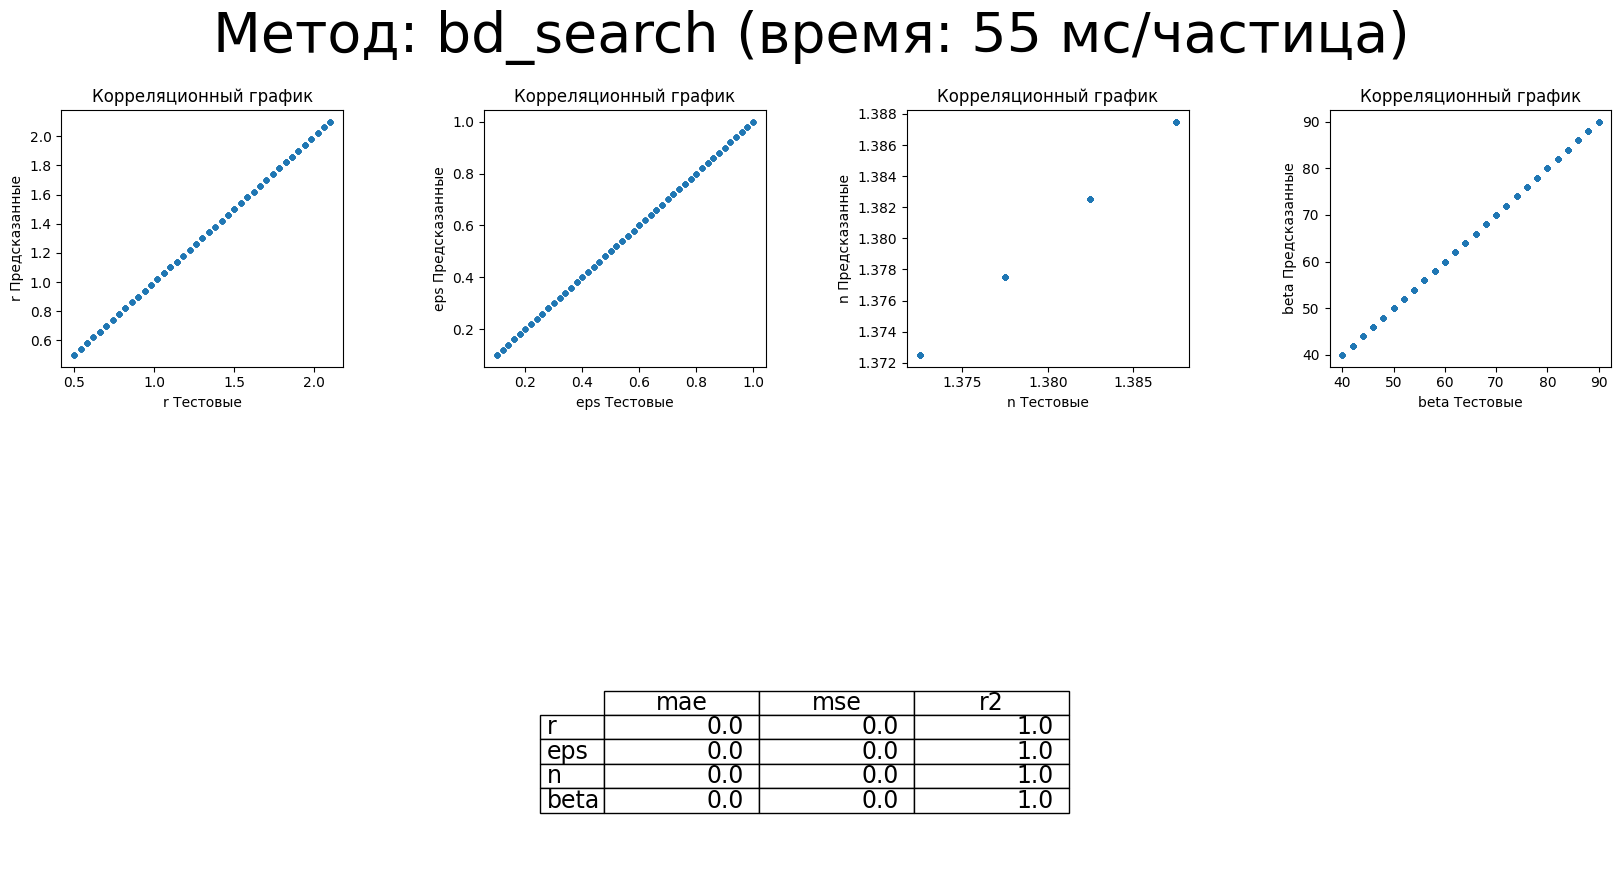

In [48]:
regr_model_resume(y_pred_bd, y_pred, method='bd_search (время: 55 мс/частица)')

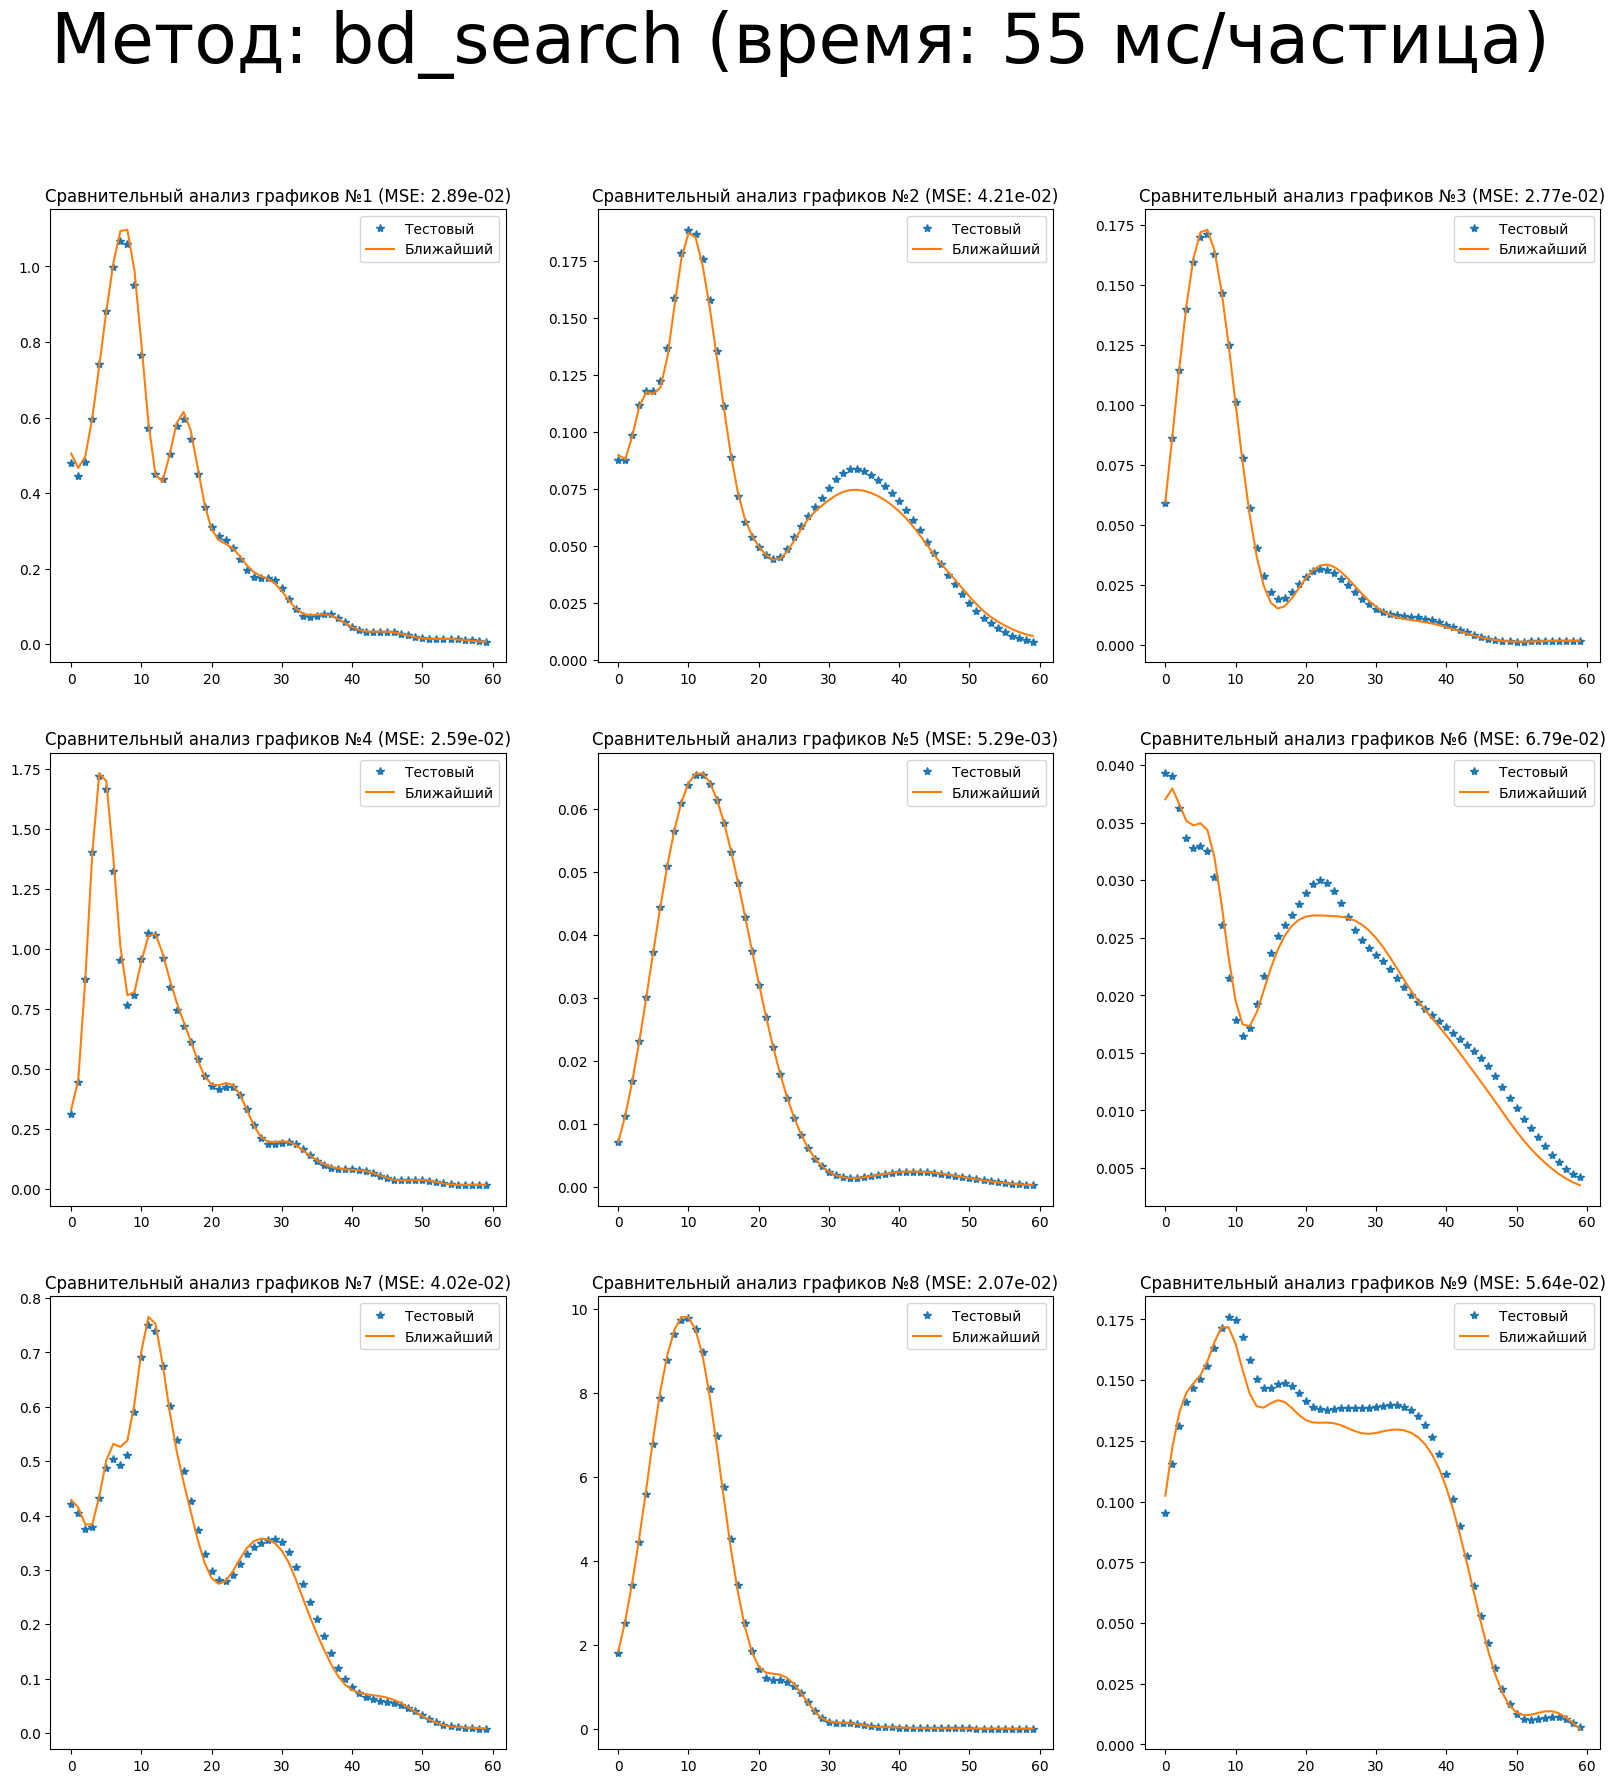

In [46]:
bd_model_resume(x_test * serc.weight, x_pred_bd, method='bd_search (время: 55 мс/частица)')